# ST1504 Part C Technical Paper

## RNN, LSTM and GRU models applied to Sentiment Analysis for comparison on efficiency and test accuracy

### Name: Haja Amir Rahman
### Class: DAAA/FT?2B/06
### Admin Number: P2100803

### References: 

- [Twitter Dataset](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv)
- [Using GloVe and Pretrained Embedding layers](https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.Y3sIcXZByUk)
- [GloVe Model Loading](https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt)
- [Understanding Embedding Layers in Keras and GloVe](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce )

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Loading main dataset

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# data = pd.read_csv("https://raw.githubusercontent.com/haochen23/nlp-rnn-lstm-sentiment/master/training.1600000.processed.noemoticon.csv", header=None, encoding='cp437')
# print("The shape of the original dataset is {}".format(data.shape))
# data

raw = pd.read_csv('data/Twitter_Data.csv')
raw

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [4]:
raw.rename(columns={'clean_text': 'clean_comment'}, inplace=True)
raw

,clean_comment,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [5]:
raw['category'].value_counts()

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

#### Sampling to make number of data counts equal for each category

In [6]:
# NUM = 8277

# positive = raw[raw['category']==1].sample(8277)
# neutral = raw[raw['category']==0].sample(8277)
# negative = raw[raw['category']==-1].sample(8277)

NUM = 35510

positive = raw[raw['category']==1].sample(NUM)
neutral = raw[raw['category']==0].sample(NUM)
negative = raw[raw['category']==-1].sample(NUM)

data = pd.concat([positive, neutral, negative], axis=0).sample(frac=1)
# positive.shape, neutral.shape, negative.shape

data

,clean_comment,category
23277,will ensure that family and mohalla will the v...,1.0
76802,for example what modi delivers fake strike fai...,-1.0
53969,indian national congress inc was power for yea...,1.0
17367,did modi make even his last budget,0.0
161730,coincidence that many big economist like raghu...,1.0
...,...,...
78087,for surgical strike credit goes soldiers not f...,1.0
13709,modi for life dynasty bandits,0.0
5176,accept modi has minimum cocaine dose,0.0
46805,sir you didnt congratulated modi,0.0


In [7]:
def load_glove_model(glove_file, encoding='iso-8859-1'):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding=encoding) as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.blank("en")

def remove_stopwords(sentence):
    '''
    function to remove stopwords
        input: sentence - string of sentence
    '''
    new = []
    # tokenize sentence
    sentence = nlp(sentence)
    for tk in sentence:
        if (tk.is_stop == False) & (tk.pos_ !="PUNCT"):
            new.append(tk.string.strip())
    # convert back to sentence string
    c = " ".join(str(x) for x in new)
    return c


def lemmatize(sentence):
    '''
    function to do lemmatization
        input: sentence - string of sentence
    '''
    sentence = nlp(sentence)
    s = ""
    for w in sentence:
        s +=" "+w.lemma_
    return nlp(s)

def sent_vectorizer(sent, model):
    '''
    sentence vectorizer using the pretrained glove model
    '''
    sent_vector = np.zeros(200)
    num_w = 0
    for w in sent.split():
        try:
            # add up all token vectors to a sent_vector
            sent_vector = np.add(sent_vector, model[str(w)])
            num_w += 1
        except:
            pass
    return sent_vector

In [8]:
data_X = data['clean_comment'].to_numpy().astype('str')
data_y = data['category']
data_y = pd.get_dummies(data_y).to_numpy()

data_X.shape, data_y.shape

((106530,), (106530, 3))

### Loading GloVe Model

In [9]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt", encoding='utf-8')
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)

[INFO]Loading GloVe Model...
[INFO] Done...1193514 words loaded!


### Tokenizing 

In [10]:
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

data_keras.shape

Found 87936 unique tokens.


(106530, 15)

## Train-test-split

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_keras, data_y, test_size = 0.3, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((74571, 15), (31959, 15), (74571, 3), (31959, 3))

In [12]:
# calculate number of words
nb_words = len(tokenizer.word_index) + 1
print(f"Number of words: {nb_words}")

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))

for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Number of words: 87937
Null word embeddings: 51891


In [13]:
# adopted from sent_tran_eval.py
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):
    '''
    build_model function:
    inputs: 
        rnn_model - which type of RNN layer to use, choose in (SimpleRNN, LSTM, GRU)
        embedding_matrix - whether to use pretrained embeddings or not
    '''
    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        200, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        200, 
                        input_length= max_len,
                        trainable = False))
        
    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(256))
      
    elif rnn_model == "LSTM":
        model.add(LSTM(256))
    else:
        model.add(GRU(256))

    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                optimizer='rmsprop',
                metrics=['accuracy'])
    return model

## RNN Model

In [15]:
model_rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
model_rnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnn.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model_rnn_history = model_rnn.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                               early_stop, rlrop])
model_rnn.summary()
predictions = model_rnn.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 200)           17587400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               116992    
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 18,100,171
Trainable params: 512,771
Non-trainable params: 17,587,400
_________________________________________________________________
Epoch 1/30
2331/2331 [================

In [16]:
# evaluating baseline coarse model
print(model_rnn.evaluate(x_test, y_test))
model_rnn.load_weights('tmp/checkpoint/model_rnnAcc.hdf5')
scoreAcc = model_rnn.evaluate(x_test, y_test)
model_rnn.load_weights('tmp/checkpoint/model_rnnLoss.hdf5')
scoreLoss = model_rnn.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

999/999 [==============================] - 7s 7ms/step - loss: 0.6759 - accuracy: 0.7466
[0.6758729219436646, 0.7465502619743347]
999/999 [==============================] - 7s 7ms/step - loss: 0.6629 - accuracy: 0.7363
Best Acc Test Loss: 0.6758729219436646
Best Acc Test Accuracy: 74.66000000000001 %
Best Loss Test Loss: 0.6629405617713928
Best Loss Test Accuracy: 73.63 %


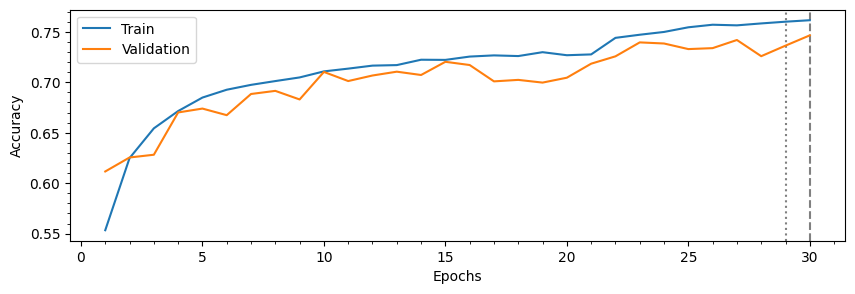

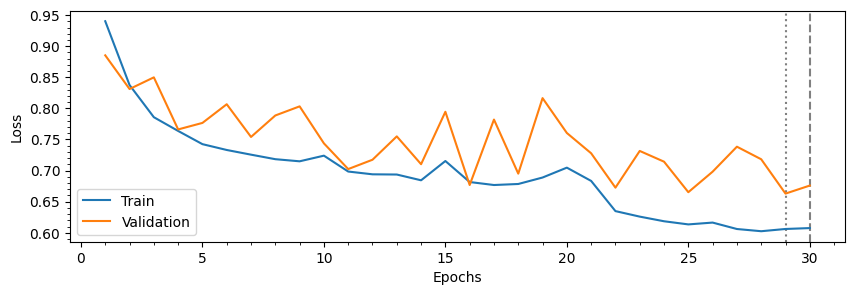

In [17]:
max_val_acc_epoch = np.argmax(list(model_rnn_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_rnn_history.history['val_loss']))+1
epochs = range(1, len(model_rnn_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['accuracy'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['loss'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_rnn, legend=True)

In [19]:
model_rnn.save_weights("./tmp/rnn-model.h5")

## LSTM Model

In [20]:
model_lstm = build_model(nb_words, "LSTM", embedding_matrix)
model_lstm.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstm.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model_lstm_history = model_lstm.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                early_stop, rlrop])

predictions = model_lstm.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 200)           17587400  
                                                                 
 lstm (LSTM)                 (None, 256)               467968    
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 18,451,147
Trainable params: 863,747
Non-trainable params: 17,587,400
_________________________________________________________________
Epoch 1/30
2328/2331 [==============

In [21]:
# evaluating baseline coarse model
print(model_lstm.evaluate(x_test, y_test))
model_lstm.load_weights('tmp/checkpoint/model_lstmAcc.hdf5')
scoreAcc = model_lstm.evaluate(x_test, y_test)
model_lstm.load_weights('tmp/checkpoint/model_lstmLoss.hdf5')
scoreLoss = model_lstm.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

999/999 [==============================] - 3s 3ms/step - loss: 0.5231 - accuracy: 0.8012
[0.5231138467788696, 0.8011514544487]
999/999 [==============================] - 3s 3ms/step - loss: 0.5231 - accuracy: 0.8012
Best Acc Test Loss: 0.6030269265174866
Best Acc Test Accuracy: 80.7 %
Best Loss Test Loss: 0.5231138467788696
Best Loss Test Accuracy: 80.12 %


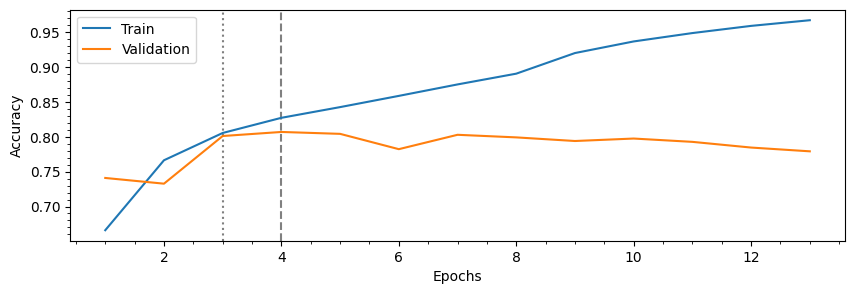

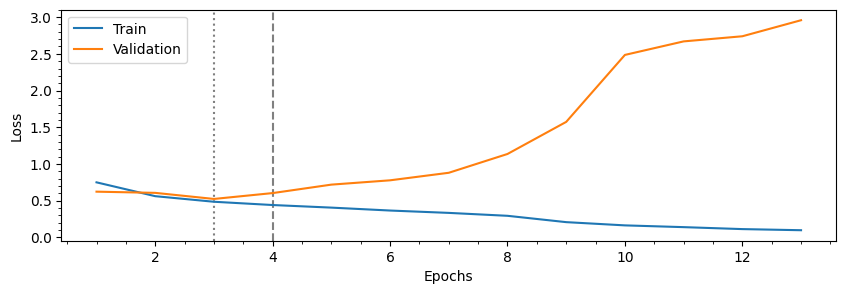

In [22]:
max_val_acc_epoch = np.argmax(list(model_lstm_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_lstm_history.history['val_loss']))+1
epochs = range(1, len(model_lstm_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['accuracy'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['loss'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_lstm, legend=True)

In [24]:
# model_lstm.save_weights("models/model-lstm.h5")

## GRU Model 

In [25]:
model_gru = build_model(nb_words, "GRU", embedding_matrix)
model_gru.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gru.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model_gru_history = model_gru.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                early_stop, rlrop])

predictions = model_gru.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 200)           17587400  
                                                                 
 gru (GRU)                   (None, 256)               351744    
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 18,334,923
Trainable params: 747,523
Non-trainable params: 17,587,400
_________________________________________________________________
Epoch 1/30
2324/2331 [==============

In [26]:
# evaluating baseline coarse model
print(model_gru.evaluate(x_test, y_test))
model_gru.load_weights('tmp/checkpoint/model_gruAcc.hdf5')
scoreAcc = model_gru.evaluate(x_test, y_test)
model_gru.load_weights('tmp/checkpoint/model_gruLoss.hdf5')
scoreLoss = model_gru.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

999/999 [==============================] - 3s 3ms/step - loss: 0.5282 - accuracy: 0.8026
[0.5281931161880493, 0.8025908470153809]
999/999 [==============================] - 3s 3ms/step - loss: 0.5282 - accuracy: 0.8026
Best Acc Test Loss: 0.838775634765625
Best Acc Test Accuracy: 80.46 %
Best Loss Test Loss: 0.5281931161880493
Best Loss Test Accuracy: 80.25999999999999 %


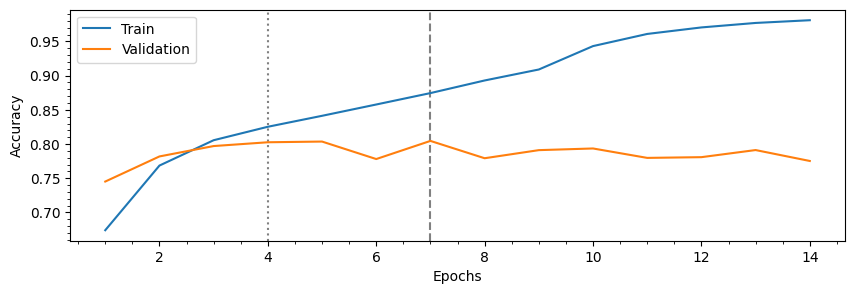

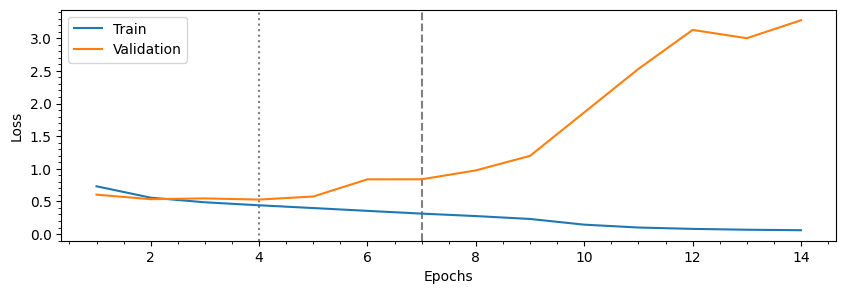

In [27]:
max_val_acc_epoch = np.argmax(list(model_gru_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_gru_history.history['val_loss']))+1
epochs = range(1, len(model_gru_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['accuracy'], label='Train')
plt.plot(epochs,model_gru_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['loss'], label='Train')
plt.plot(epochs,model_gru_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_gru, legend=True)

In [29]:
# model_gru.save_weights("models/model-gru.h5")

### Using a non-deep learning model (TFIDF vectorization) and other effective, traditional machine learning models

In [30]:
data

,clean_comment,category
23277,will ensure that family and mohalla will the v...,1.0
76802,for example what modi delivers fake strike fai...,-1.0
53969,indian national congress inc was power for yea...,1.0
17367,did modi make even his last budget,0.0
161730,coincidence that many big economist like raghu...,1.0
...,...,...
78087,for surgical strike credit goes soldiers not f...,1.0
13709,modi for life dynasty bandits,0.0
5176,accept modi has minimum cocaine dose,0.0
46805,sir you didnt congratulated modi,0.0


In [31]:
from sklearn.model_selection import train_test_split

x = data['clean_comment'].astype('str')
y = data['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

x_train_vec.shape, x_test_vec.shape 

((85224, 10000), (21306, 10000))

## RandomForestClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(x_train_vec, y_train)
model_rf.score(x_test_vec, y_test)

predictions = model_rf.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.80      0.78      0.79      7121
         0.0       0.81      0.90      0.86      7082
         1.0       0.86      0.78      0.82      7103

    accuracy                           0.82     21306
   macro avg       0.82      0.82      0.82     21306
weighted avg       0.82      0.82      0.82     21306



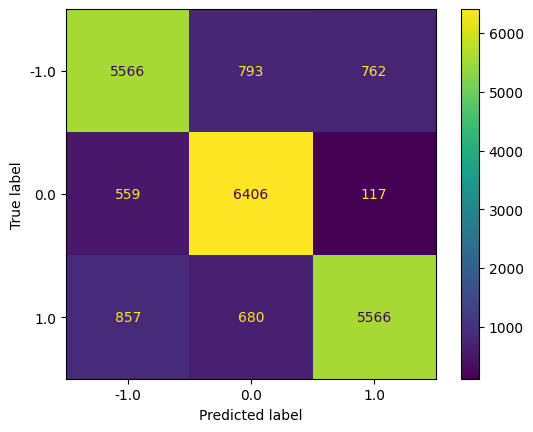

In [34]:
cm = confusion_matrix(y_test, predictions, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot()


## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(x_train_vec, y_train)
model_lr.score(x_test_vec, y_test)

predictions = model_lr.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.91      0.88      0.89      7121
         0.0       0.89      0.97      0.93      7082
         1.0       0.93      0.87      0.90      7103

    accuracy                           0.91     21306
   macro avg       0.91      0.91      0.90     21306
weighted avg       0.91      0.91      0.90     21306



c:\Users\P2100803\.conda\envs\gpu\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


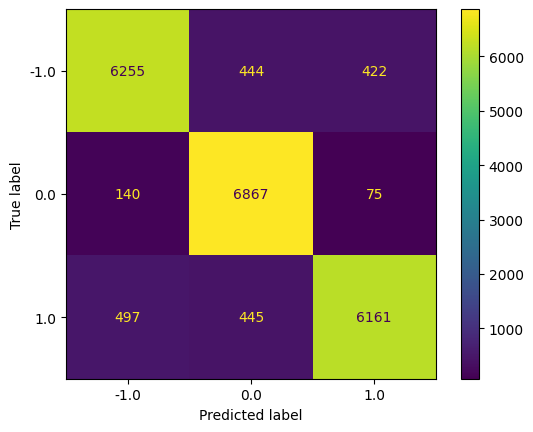

In [36]:
cm = confusion_matrix(y_test, predictions, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot()
